<a href="https://colab.research.google.com/github/WilhelmWillie/i-love-produce/blob/master/i_love_produce_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone the i-love-produce repo and get latest test data

!git clone https://github.com/WilhelmWillie/i-love-produce.git

Cloning into 'i-love-produce'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 177 (delta 2), reused 11 (delta 2), pack-reused 164
Receiving objects: 100% (177/177), 86.09 MiB | 12.43 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [3]:
# Verify we have a test, train, and validation folder
!ls i-love-produce/dataset

test  train  validation


In [0]:
# Importing the right libraries

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_hub as hub

import os 
import time 

In [7]:
# Set up paths for training and validation directory
base_dir = os.path.join(os.getcwd(), 'i-love-produce', 'dataset')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

print(base_dir, train_dir, validation_dir, test_dir)

/content/i-love-produce/dataset /content/i-love-produce/dataset/train /content/i-love-produce/dataset/validation /content/i-love-produce/dataset/test


In [0]:
# Count number of training and validation datapoints
train_tomato_dir = os.path.join(train_dir, 'tomato')
train_carrot_dir = os.path.join(train_dir, 'carrot')
train_onion_dir = os.path.join(train_dir, 'onion')

validation_tomato_dir = os.path.join(validation_dir, 'tomato')
validation_carrot_dir = os.path.join(validation_dir, 'carrot')
validation_onion_dir = os.path.join(validation_dir, 'onion')

num_tomato_tr = len(os.listdir(train_tomato_dir))
num_carrot_tr = len(os.listdir(train_carrot_dir))
num_onion_tr = len(os.listdir(train_onion_dir))

num_tomato_val = len(os.listdir(validation_tomato_dir))
num_carrot_val = len(os.listdir(validation_carrot_dir))
num_onion_val = len(os.listdir(validation_onion_dir))

total_train = num_tomato_tr + num_carrot_tr + num_onion_tr
total_val = num_tomato_val + num_carrot_val + num_onion_val

In [0]:
# Key variables
IMAGE_RES = 299
BATCH_SIZE = 40
NUM_CLASSES = 3

In [10]:
# Set up training data w/ image augmentation
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.5,
    horizontal_flip=True,
)

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMAGE_RES,IMAGE_RES),
                                                     class_mode='sparse',
                                                     color_mode='rgb'
                                                    )

Found 90 images belonging to 3 classes.


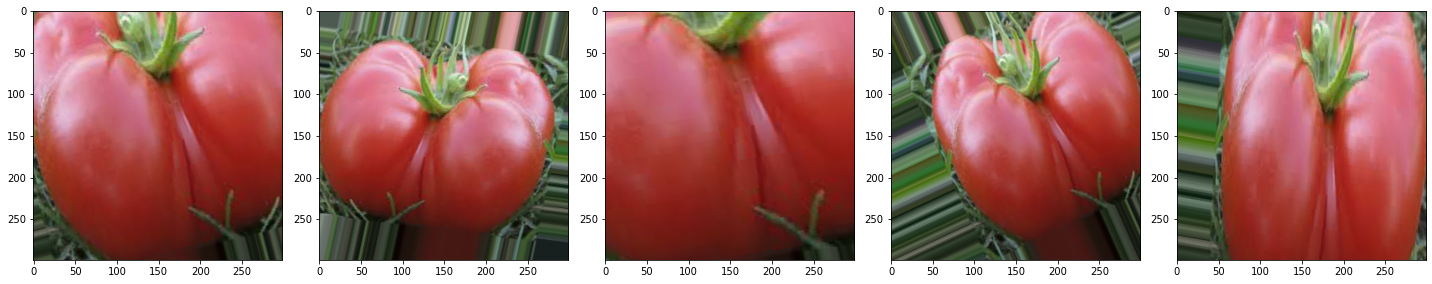

In [11]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [12]:
# Set up validation data w/ no image augmentation
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMAGE_RES, IMAGE_RES),
                                                 class_mode='sparse',
                                                 color_mode='rgb')

Found 60 images belonging to 3 classes.


In [59]:
# Set up our model which is a CNN w/ some dropout
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMAGE_RES, IMAGE_RES, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(NUM_CLASSES)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 297, 297, 64)      1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 146, 146, 128)     73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 73, 73, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 71, 71, 256)       295168    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 35, 35, 256)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 35, 35, 256)      

In [15]:
# Train our model with a set number of epochs
epochs = 40

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/40
3/3 [==============================] - ETA: 0s - loss: 4.0039 - accuracy: 0.3333

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


3/3 [==============================] - 4s 1s/step - loss: 4.0039 - accuracy: 0.3333 - val_loss: 1.6556 - val_accuracy: 0.3500
Epoch 2/40
3/3 [==============================] - 4s 1s/step - loss: 1.4495 - accuracy: 0.3333 - val_loss: 1.0957 - val_accuracy: 0.4500
Epoch 3/40
3/3 [==============================] - 4s 1s/step - loss: 1.0962 - accuracy: 0.4556 - val_loss: 1.0834 - val_accuracy: 0.4833
Epoch 4/40
3/3 [==============================] - 4s 1s/step - loss: 1.0981 - accuracy: 0.2667 - val_loss: 1.0783 - val_accuracy: 0.3333
Epoch 5/40
3/3 [==============================] - 4s 1s/step - loss: 1.0726 - accuracy: 0.3556 - val_loss: 1.0663 - val_accuracy: 0.4000
Epoch 6/40
3/3 [==============================] - 4s 1s/step - loss: 1.0575 - accuracy: 0.3889 - val_loss: 1.0713 - val_accuracy: 0.3333
Epoch 7/40
3/3 [==============================] - 4s 1s/step - loss: 1.0741 - accuracy: 0.3333 - val_loss: 1.0176 - val_accuracy: 0.3667
Epoch 8/40
3/3 [==============================] - 5s

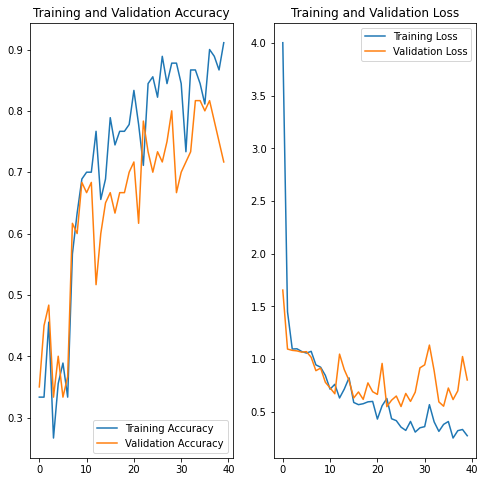

In [16]:
# Plot our training metrics (potentially identify room for improvement)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [65]:
# Set up our test data
test_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                  directory=test_dir,
                                                 target_size=(IMAGE_RES, IMAGE_RES),
                                                 class_mode='sparse',
                                                 color_mode='rgb')

Found 2 images belonging to 2 classes.


In [66]:
# Predict!
pred = model.predict(test_data_gen)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_data_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())

predictions = [labels[k] for k in predicted_class_indices]

print(predictions)

['tomato', 'tomato']


In [35]:
# If model is good, save it!
t = time.time()
file_name = int(t)

export_path_sm = "./{}".format(file_name)
tf.saved_model.save(model, export_path_sm)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./1590130775/assets


In [36]:
!zip model.zip -r $file_name

  adding: 1590130775/ (stored 0%)
  adding: 1590130775/saved_model.pb (deflated 89%)
  adding: 1590130775/assets/ (stored 0%)
  adding: 1590130775/variables/ (stored 0%)
  adding: 1590130775/variables/variables.data-00001-of-00002 (deflated 17%)
  adding: 1590130775/variables/variables.data-00000-of-00002 (deflated 81%)
  adding: 1590130775/variables/variables.index (deflated 67%)
